In [1]:
import torch
import torch.nn as nn

def hash(coords, log2_hashmap_size):
    '''
    coords: this function can process upto 7 dim coordinates
    log2T:  logarithm of T w.r.t 2
    '''
    primes = [1, 2654435761, 805459861, 3674653429, 2097192037, 1434869437, 2165219737]

    xor_result = torch.zeros_like(coords)[..., 0] # 任何数与0做位异或操作结果都是这个数本身!
    for i in range(coords.shape[-1]):
        xor_result ^= coords[..., i]*primes[i]    # python中^是按位异或运算符，运算规则是：将两个数的二进制按位对比，如果相同（都为1或者都为0），则运算结果的对应位上是0，否则为1

    return torch.tensor((1<<log2_hashmap_size)-1).to(xor_result.device) & xor_result # 1 << log2_hashmap_size代表将1的二进制左移log2_hashmap_size位，然后在其右边全补上0，将结果换算为十进制等于2的log2_hashmap_size次方
                                                                                     # 2的N次方-1在二进制中是一个十分特殊的数，它右N个1从最右向左依次排列组成
                                                                                     
                                                                                     # python中&是位与运算符，运算规则是：将两个数的二进制按位对比，都为1，则结果的对应位上是1，否则为0
                                                                                     # 对于一个数x（十进制），x mod 2的N次方 等价于取x的二进制的后N位数（得到的是二进制，需要将其转化为十进制）
                                                                                     # 例如，对109（十进制），x mod 2的4次方(16) = 13:
                                                                                     # 109的二进制为1101101
                                                                                     #  13的二进制为   1101
                                                                                     # 因此这行代码等效于 xor_result mod 2的log2_hashmap_size

def get_voxel_vertices(xyz, bounding_box, resolution, log2_hashmap_size):
    '''
    xyz: 3D coordinates of samples. B x 3
    bounding_box: min and max x,y,z coordinates of object bbox
    resolution: number of voxels per axis
    '''
    box_min, box_max = bounding_box.to(xyz.device)
    BOX_OFFSETS = torch.tensor([[[i,j,k] for i in [0, 1] for j in [0, 1] for k in [0, 1]]]).to(xyz.device)
    
    keep_mask = xyz==torch.max(torch.min(xyz, box_max), box_min)
    if not torch.all(xyz <= box_max) or not torch.all(xyz >= box_min):
        # print("ALERT: some points are outside bounding box. Clipping them!")
        xyz = torch.clamp(xyz, min=box_min, max=box_max)

    grid_size = (box_max-box_min)/resolution
    
    bottom_left_idx = torch.floor((xyz-box_min)/grid_size).int() # bottom_left_idx.shape = [B, 3]
    voxel_min_vertex = bottom_left_idx*grid_size + box_min
    voxel_max_vertex = voxel_min_vertex + torch.tensor([1.0,1.0,1.0]).to(xyz.device)*grid_size

    voxel_indices = bottom_left_idx.unsqueeze(1) + BOX_OFFSETS # shape: [B, 1, 3] +　[1, 8, 3]
    hashed_voxel_indices = hash(voxel_indices, log2_hashmap_size)

    return voxel_min_vertex, voxel_max_vertex, hashed_voxel_indices, keep_mask

class HashEmbedder(nn.Module):
    def __init__(self, bounding_box, n_levels=16, n_features_per_level=2,\
                log2_hashmap_size=19, base_resolution=16, finest_resolution=512):
        super(HashEmbedder, self).__init__()
        self.bounding_box = bounding_box
        self.n_levels = n_levels                                  # 多少个级别的hashmap，对应论文中的L
        self.n_features_per_level = n_features_per_level          # hashmap中的每个特征的维度，对应论文中的F
        self.log2_hashmap_size = log2_hashmap_size                # 每个hashmap中有多少个特征（2的指数次个），对应论文中的T
        self.base_resolution = torch.tensor(base_resolution)
        self.finest_resolution = torch.tensor(finest_resolution)
        self.out_dim = self.n_levels * self.n_features_per_level

        self.b = torch.exp((torch.log(self.finest_resolution)-torch.log(self.base_resolution))/(n_levels-1))

        # nn.Embedding(num_embeddings, embedding_dim)创建了一个Lookup table, 用来实现hashmap
        # Parameters:
        # num_beddings: 特征的数量 embedding_dim：每个特征的维度
        self.embeddings = nn.ModuleList([nn.Embedding(2**self.log2_hashmap_size, \
                                        self.n_features_per_level) for i in range(n_levels)])
        # custom uniform initialization
        for i in range(n_levels):
            nn.init.uniform_(self.embeddings[i].weight, a=-0.0001, b=0.0001)
            # self.embeddings[i].weight.data.zero_()
        

    def trilinear_interp(self, x, voxel_min_vertex, voxel_max_vertex, voxel_embedds):
        '''
        x: B x 3
        voxel_min_vertex: B x 3
        voxel_max_vertex: B x 3
        voxel_embedds: B x 8 x 2
        '''
        # source: https://en.wikipedia.org/wiki/Trilinear_interpolation
        weights = (x - voxel_min_vertex)/(voxel_max_vertex-voxel_min_vertex) # B x 3

        # step 1
        # 0->000, 1->001, 2->010, 3->011, 4->100, 5->101, 6->110, 7->111
        c00 = voxel_embedds[:,0]*(1-weights[:,0][:,None]) + voxel_embedds[:,4]*weights[:,0][:,None]
        c01 = voxel_embedds[:,1]*(1-weights[:,0][:,None]) + voxel_embedds[:,5]*weights[:,0][:,None]
        c10 = voxel_embedds[:,2]*(1-weights[:,0][:,None]) + voxel_embedds[:,6]*weights[:,0][:,None]
        c11 = voxel_embedds[:,3]*(1-weights[:,0][:,None]) + voxel_embedds[:,7]*weights[:,0][:,None]

        # step 2
        c0 = c00*(1-weights[:,1][:,None]) + c10*weights[:,1][:,None]
        c1 = c01*(1-weights[:,1][:,None]) + c11*weights[:,1][:,None]

        # step 3
        c = c0*(1-weights[:,2][:,None]) + c1*weights[:,2][:,None]

        return c

    def forward(self, x):
        # x is 3D point position: B x 3
        x_embedded_all = []
        for i in range(self.n_levels):
            resolution = torch.floor(self.base_resolution * self.b**i)
            voxel_min_vertex, voxel_max_vertex, hashed_voxel_indices, keep_mask = get_voxel_vertices(\
                                                x, self.bounding_box, \
                                                resolution, self.log2_hashmap_size)
            
            voxel_embedds = self.embeddings[i](hashed_voxel_indices)

            x_embedded = self.trilinear_interp(x, voxel_min_vertex, voxel_max_vertex, voxel_embedds)
            x_embedded_all.append(x_embedded)

        keep_mask = keep_mask.sum(dim=-1)==keep_mask.shape[-1]
        return torch.cat(x_embedded_all, dim=-1), keep_mask

1. 设置测试函数，生成训练集与测试集

In [2]:
import torch

print('The number of available GPU:',torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f'GPU{i}: {torch.cuda.get_device_name(i)}')

Device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'[{Device}] on!')

The number of available GPU: 3
GPU0: NVIDIA GeForce RTX 3090
GPU1: NVIDIA GeForce RTX 3090
GPU2: NVIDIA GeForce RTX 3090
[cuda:0] on!


In [3]:
import torch
import torch.nn as nn

def TestFunction(x):
    '''
    x is 3D points position B x 3
    '''
    # result = torch.sin(torch.pi*x[..., 0]) + torch.cos(torch.pi*x[..., 1]) + torch.sin(2*torch.pi*x[..., 2])
    # result = torch.sqrt(x[..., 0]**2 + x[..., 0]**2 + x[..., 2]**2)
    result = x[..., 0 ] + x[..., 1]+ x[..., 2]
    return result

bounding_box = torch.tensor([[-5, -5, -5], [5, 5, 5]])

def get_dataset(bouding_box, batch_size = 100, noise_std = 0.01):
    coords_min = bouding_box[0]
    coords_max = bouding_box[1]
    length = coords_max - coords_min
    weight = torch.rand([batch_size, 3])
    coords = coords_min + length * weight
    
    real_value = TestFunction(coords)
    noise = torch.randn(real_value.shape) * noise_std
    value_withNoisy = real_value + noise
    
    return coords, value_withNoisy

trainDataset_inputs, trainDataset_outputs = get_dataset(bounding_box, batch_size = 10000)
testDataset_inputs, testDataset_outputs = get_dataset(bounding_box)

2. 神经网络构建与训练

In [4]:
from torch.utils.data import DataLoader, TensorDataset
import time

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim = 256, output_dim = 1):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.LeakyReLU(negative_slope = 0.01)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.LeakyReLU(negative_slope = 0.01)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.LeakyReLU(negative_slope = 0.01)
        self.fc4 = nn.Linear(hidden_dim,  output_dim)
        
    def forward(self, x):
        t = x
        t = self.relu1(self.fc1(t))
        t = self.relu2(self.fc2(t))
        t = self.relu3(self.fc3(t))
        result = self.fc4(t)
        return result

if torch.cuda.device_count() > 1:
    print(f'Multi-GPU training!')
    MLPmodel = nn.DataParallel(SimpleMLP(input_dim = 32))
    MLPmodel = MLPmodel.to(Device)
    hashembedder = nn.DataParallel(HashEmbedder(bounding_box))
    hashembedder = hashembedder.to(Device)
else:
    print(f'single GPU training: [{Device}]')
    MLPmodel = SimpleMLP(input_dim = 32).to(Device)
    hashembedder = HashEmbedder(bounding_box).to(Device)

mini_batchSize = 500
train_loader = DataLoader(
    dataset = TensorDataset(trainDataset_inputs, trainDataset_outputs),
    batch_size = mini_batchSize,
    shuffle = True
)

optimizer = torch.optim.Adam(list(MLPmodel.parameters()) + list(hashembedder.parameters()), lr = 0.001)
mse = nn.MSELoss()
num_epochs = 100
trainingTime_start = time.time()
for epoch in range(num_epochs):
    MLPmodel.train()
    hashembedder.train()
    for miniBatch_trainingInputs, miniBatch_trainingOutputs in train_loader:
        miniBatch_trainingInputs = miniBatch_trainingInputs.to(Device)
        miniBatch_trainingOutputs = miniBatch_trainingOutputs.to(Device)
        optimizer.zero_grad()
        miniBatch_trainingEncodingInputs, _ = hashembedder(miniBatch_trainingInputs)
        predictedValue = MLPmodel(miniBatch_trainingEncodingInputs)
        loss = mse(miniBatch_trainingOutputs.unsqueeze(-1), predictedValue)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 2 == 0:
        MLPmodel.eval()
        hashembedder.eval()
        with torch.no_grad():
            testDataset_encodingInputs, _ = hashembedder(testDataset_inputs.to(Device))
            predictedValue_testDataset = MLPmodel(testDataset_encodingInputs)
            test_loss = mse(testDataset_outputs.to(Device).unsqueeze(-1), predictedValue_testDataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss.item():.4f}')
trainingTime_end = time.time()
print('\nTraining finished!')
print(f'Training Time: {trainingTime_end - trainingTime_start} s')

Multi-GPU training!
Epoch [2/100], Test Loss: 22.2483
Epoch [4/100], Test Loss: 4.6095
Epoch [6/100], Test Loss: 2.5290
Epoch [8/100], Test Loss: 2.3601
Epoch [10/100], Test Loss: 2.3534
Epoch [12/100], Test Loss: 2.4174
Epoch [14/100], Test Loss: 2.4419
Epoch [16/100], Test Loss: 2.4281
Epoch [18/100], Test Loss: 2.3954
Epoch [20/100], Test Loss: 2.2853
Epoch [22/100], Test Loss: 2.2202
Epoch [24/100], Test Loss: 2.1204
Epoch [26/100], Test Loss: 1.9129
Epoch [28/100], Test Loss: 1.8637
Epoch [30/100], Test Loss: 1.6274
Epoch [32/100], Test Loss: 1.5211
Epoch [34/100], Test Loss: 1.4439
Epoch [36/100], Test Loss: 1.3380
Epoch [38/100], Test Loss: 1.2692
Epoch [40/100], Test Loss: 1.2551
Epoch [42/100], Test Loss: 1.1612
Epoch [44/100], Test Loss: 1.1844
Epoch [46/100], Test Loss: 1.1502
Epoch [48/100], Test Loss: 1.1052
Epoch [50/100], Test Loss: 1.1295
Epoch [52/100], Test Loss: 1.0480
Epoch [54/100], Test Loss: 1.0037
Epoch [56/100], Test Loss: 1.0152
Epoch [58/100], Test Loss: 1.00


Starting visualization...


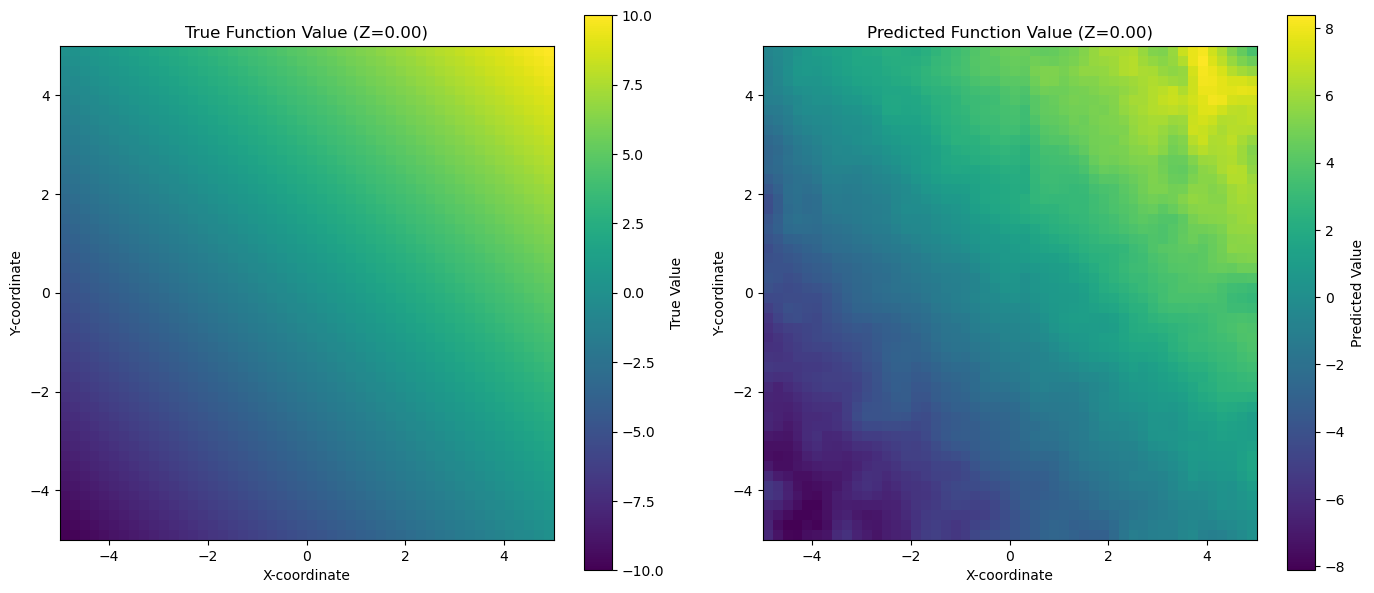

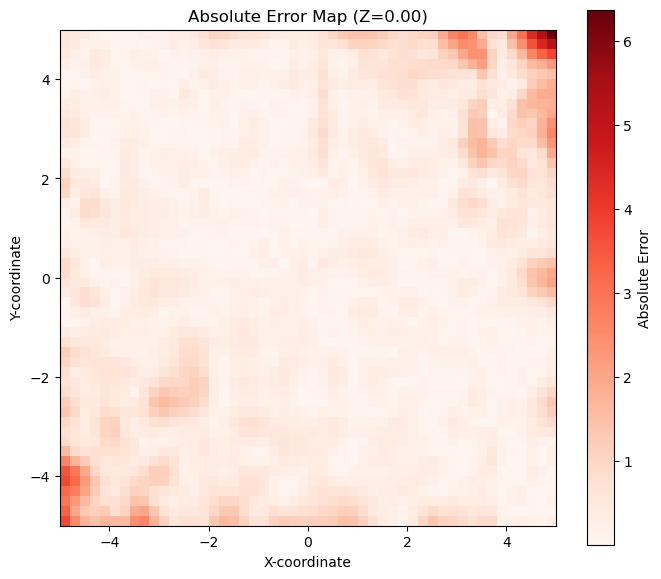

In [5]:
import matplotlib.pyplot as plt
import numpy as np
print("\nStarting visualization...")
# 设置可视化网格的参数
resolution_vis = 50 # 网格点的数量，例如 50x50
# 确保 bounding_box 已经定义并移动到正确的设备上
# 假设 bounding_box = torch.tensor([[-5, -5, -5], [5, 5, 5]]).to(Device) 已经在前面定义
x_coords = torch.linspace(bounding_box[0,0].item(), bounding_box[1,0].item(), resolution_vis)
y_coords = torch.linspace(bounding_box[0,1].item(), bounding_box[1,1].item(), resolution_vis)
# 创建一个 2D 网格，并固定 z 为 0 （或边界内的任何常数）
# 例如，我们固定 z 为 bounding_box 的中心点 z 坐标
fixed_z = (bounding_box[0,2] + bounding_box[1,2]) / 2
# 使用 meshgrid 创建 x-y 平面上的坐标
# xx: resolution_vis x resolution_vis (x 值重复)
# yy: resolution_vis x resolution_vis (y 值重复)
xx, yy = torch.meshgrid(x_coords, y_coords, indexing='ij') # 使用 'ij' 保持矩阵索引习惯
# 将网格展平并组合成 B x 3 的形式
# B = resolution_vis * resolution_vis
grid_points = torch.stack([xx.flatten(), yy.flatten(), torch.full_like(xx.flatten(), fixed_z)], dim=-1).to(Device)
# 将模型设置为评估模式
MLPmodel.eval()
hashembedder.eval()
# 使用 torch.no_grad() 禁用梯度计算，节省内存并加速
with torch.no_grad():
    # 编码网格点
    embedded_grid_points, _ = hashembedder(grid_points)
    # 预测函数值
    predicted_values = MLPmodel(embedded_grid_points).cpu().numpy()
# 将预测值重塑回 2D 网格形式
predicted_values_grid = predicted_values.reshape(resolution_vis, resolution_vis)
# 计算真实值进行对比
true_values = TestFunction(grid_points).cpu().numpy().reshape(resolution_vis, resolution_vis)
# 绘制结果
plt.figure(figsize=(14, 6))
# 绘制真实函数值
plt.subplot(1, 2, 1)
plt.imshow(true_values, origin='lower', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()], cmap='viridis')
plt.colorbar(label='True Value')
plt.title(f'True Function Value (Z={fixed_z.item():.2f})') # 使用 .item() 获取标量值
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
# 绘制模型预测值
plt.subplot(1, 2, 2)
plt.imshow(predicted_values_grid, origin='lower', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()], cmap='viridis')
plt.colorbar(label='Predicted Value')
plt.title(f'Predicted Function Value (Z={fixed_z.item():.2f})')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.tight_layout()
plt.show()
# 绘制误差图
plt.figure(figsize=(7, 6))
error_map = np.abs(true_values - predicted_values_grid)
plt.imshow(error_map, origin='lower', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()], cmap='Reds')
plt.colorbar(label='Absolute Error')
plt.title(f'Absolute Error Map (Z={fixed_z.item():.2f})')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.tight_layout()
plt.show()